<a href="https://www.kaggle.com/code/chabuzy444okonkwo/ptitanicdata?scriptVersionId=223229054" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install pyspark

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
spark = SparkSession.builder.master("local[2]").appName("ml").getOrCreate()
sc = spark.sparkContext

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count, mean
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [4]:
# Initialize Spark session
spark = SparkSession.builder.appName("Titanicdatacoursework").getOrCreate()

# Load the dataset
file_path = "/kaggle/input/p2837170titanic/TitanicData.csv"  # Adjust the path as needed
titanicdata = spark.read.csv(file_path, header=True, inferSchema=True)

In [5]:
# Step 1: Data Preprocessing
# Description: Handle missing values, encode categorical features, and prepare features for ML models.
print("Initial Training Data:")
titanicdata.show(5)

Initial Training Data:
+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+--------+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|Survived|
+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+--------+
|          1|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|       0|
|          2|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|       1|
|          3|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|       1|
|          4|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|       1|
|          5|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|       0|
+-----------+------+--------------------+------+----+----

In [6]:
# Data cleaning: Drop irrelevant columns and handle missing values
# Drop columns that are not useful for prediction
columns_to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]
titanicdata = titanicdata.drop(*columns_to_drop)


In [7]:
# Handle missing values: Fill NA for Age with the average, drop rows with missing Embarked
avg_age = titanicdata.select(mean(col("Age"))).first()[0]
titanicdata = titanicdata.fillna({"Age": avg_age})
titanicdata = titanicdata.na.drop(subset=["Embarked"])

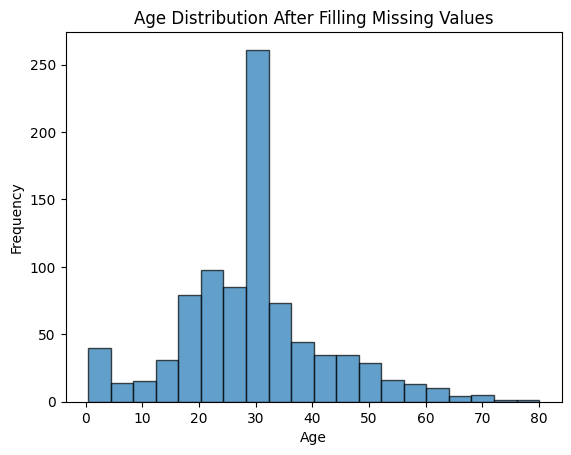

In [8]:
# Visualize Age Distribution
ages = [row["Age"] for row in titanicdata.select("Age").collect()]
plt.hist(ages, bins=20, edgecolor='k', alpha=0.7)
plt.title("Age Distribution After Filling Missing Values")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

+------+------+----+-----+-----+-------+--------+--------+
|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|Survived|
+------+------+----+-----+-----+-------+--------+--------+
|     3|  male|22.0|    1|    0|   7.25|       S|       0|
|     1|female|38.0|    1|    0|71.2833|       C|       1|
|     3|female|26.0|    0|    0|  7.925|       S|       1|
|     1|female|35.0|    1|    0|   53.1|       S|       1|
|     3|  male|35.0|    0|    0|   8.05|       S|       0|
+------+------+----+-----+-----+-------+--------+--------+
only showing top 5 rows



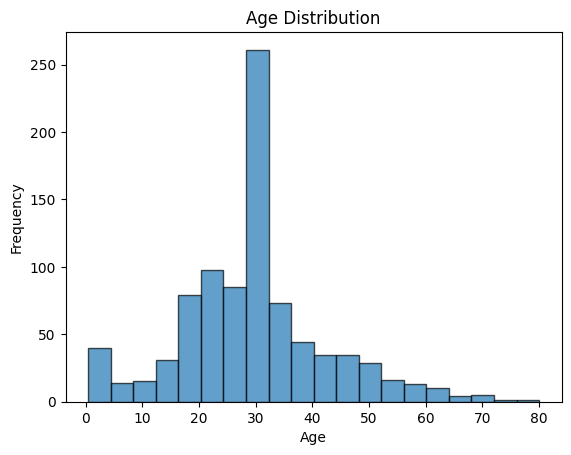

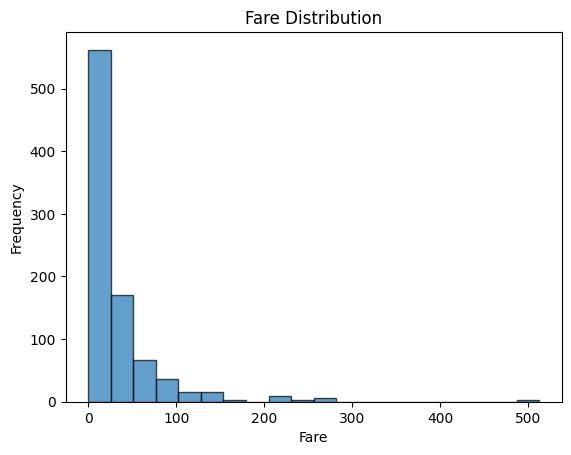

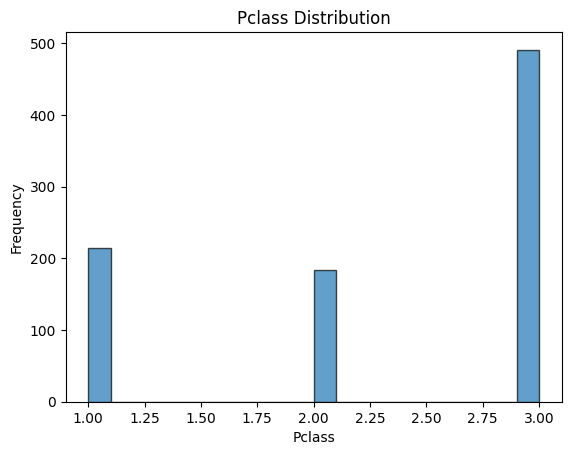

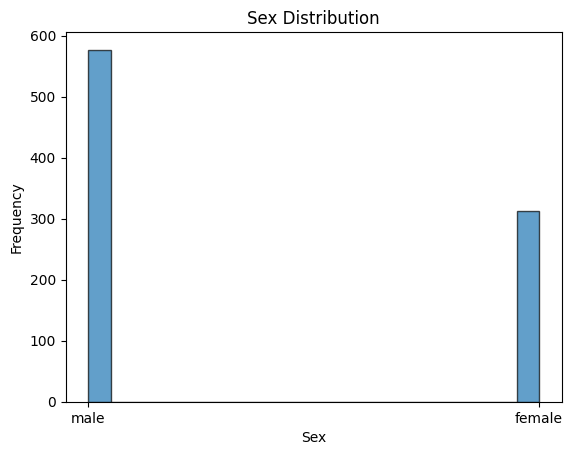

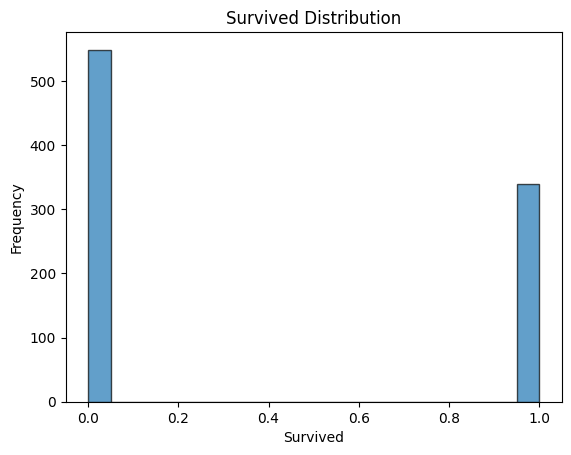

In [9]:
# Display the first few rows of the DataFrame
titanicdata.show(5)

# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame for visualization
titanicdata_pd = titanicdata.toPandas()

# Plot the distribution of the 'Age' column
plt.hist(titanicdata_pd['Age'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of the 'Fare' column
plt.hist(titanicdata_pd['Fare'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Fare Distribution')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of the 'Fare' column
plt.hist(titanicdata_pd['Pclass'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Pclass Distribution')
plt.xlabel('Pclass')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of the 'Fare' column
plt.hist(titanicdata_pd['Sex'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of the 'Fare' column
plt.hist(titanicdata_pd['Survived'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.title('Survived Distribution')
plt.xlabel('Survived')
plt.ylabel('Frequency')
plt.show()

In [10]:
titanicdata_pd.describe()

,Pclass,Age,SibSp,Parch,Fare,Survived
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,2.311586,29.653446,0.524184,0.382452,32.096681,0.382452
std,0.834700,12.968366,1.103705,0.806761,49.697504,0.486260
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.895800,0.000000
50%,3.000000,29.699118,0.000000,0.000000,14.454200,0.000000
75%,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


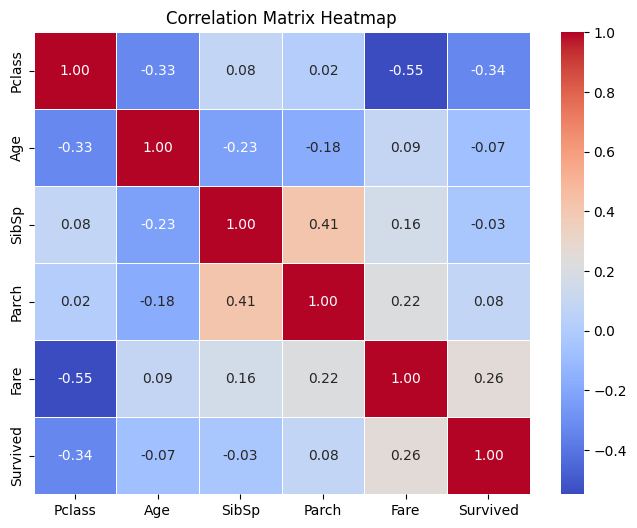

In [11]:
import seaborn as sns
# Create a heatmap of the correlation matrix
# Convert the Spark DataFrame to Pandas DataFrame for visualization
pandas_titanicdata = titanicdata.select(["Pclass", "Age", "SibSp", "Parch", "Fare", "Survived"]).toPandas()
correlation_matrix = pandas_titanicdata.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [12]:
# Data normalization and feature extraction
# Convert categorical columns to numeric
indexers = [
    StringIndexer(inputCol="Sex", outputCol="SexIndex"),
    StringIndexer(inputCol="Embarked", outputCol="EmbarkedIndex")
]
for indexer in indexers:
    titanicdata = indexer.fit(titanicdata).transform(titanicdata)

In [13]:
# Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=["Pclass", "Age", "SibSp", "Parch", "Fare", "SexIndex", "EmbarkedIndex"],
    outputCol="features"
)
titanicdata  = assembler.transform(titanicdata )


In [14]:
# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(titanicdata)
titanicdata = scaler_model.transform(titanicdata)

In [15]:
# Prepare data for classification
# Select relevant columns and rename target column
final_titanicdata = titanicdata.select(col("scaledFeatures").alias("features"), col("Survived").alias("label"))

# Split the data into training and testing sets
train_data, test_data = final_titanicdata.randomSplit([0.7, 0.3], seed=42)


In [16]:
train_data.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(7,[0,1],[1.19803...|    0|
|(7,[0,1],[1.19803...|    0|
|(7,[0,1],[1.19803...|    0|
|(7,[0,1],[1.19803...|    0|
|(7,[0,1],[2.39607...|    0|
|(7,[0,1],[2.39607...|    0|
|(7,[0,1],[2.39607...|    0|
|(7,[0,1],[3.59410...|    0|
|(7,[0,1],[3.59410...|    1|
|(7,[0,1,4],[1.198...|    1|
|(7,[0,1,4],[1.198...|    1|
|(7,[0,1,4],[1.198...|    0|
|(7,[0,1,4],[1.198...|    0|
|(7,[0,1,4],[1.198...|    0|
|(7,[0,1,4],[1.198...|    1|
|(7,[0,1,4],[1.198...|    0|
|(7,[0,1,4],[1.198...|    0|
|(7,[0,1,4],[1.198...|    0|
|(7,[0,1,4],[1.198...|    0|
|(7,[0,1,4],[1.198...|    1|
+--------------------+-----+
only showing top 20 rows



In [17]:
test_data.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(7,[0,1],[1.19803...|    0|
|(7,[0,1],[2.39607...|    0|
|(7,[0,1],[2.39607...|    0|
|(7,[0,1],[2.39607...|    0|
|(7,[0,1],[3.59410...|    0|
|(7,[0,1],[3.59410...|    0|
|(7,[0,1,4],[1.198...|    1|
|(7,[0,1,4],[1.198...|    0|
|(7,[0,1,4],[1.198...|    0|
|(7,[0,1,4],[1.198...|    1|
|(7,[0,1,4],[1.198...|    1|
|(7,[0,1,4],[1.198...|    1|
|(7,[0,1,4],[1.198...|    0|
|(7,[0,1,4],[1.198...|    0|
|(7,[0,1,4],[1.198...|    0|
|(7,[0,1,4],[1.198...|    0|
|(7,[0,1,4],[1.198...|    1|
|(7,[0,1,4],[1.198...|    1|
|(7,[0,1,4],[1.198...|    0|
|(7,[0,1,4],[1.198...|    0|
+--------------------+-----+
only showing top 20 rows



In [18]:
print(f"Train set length: {train_data.count()} records.")
print(f"Test set length: {test_data.count()} records.")

Train set length: 658 records.
Test set length: 231 records.


In [19]:
# Datatypes (Dtypes)
train_data.dtypes

[('features', 'vector'), ('label', 'int')]

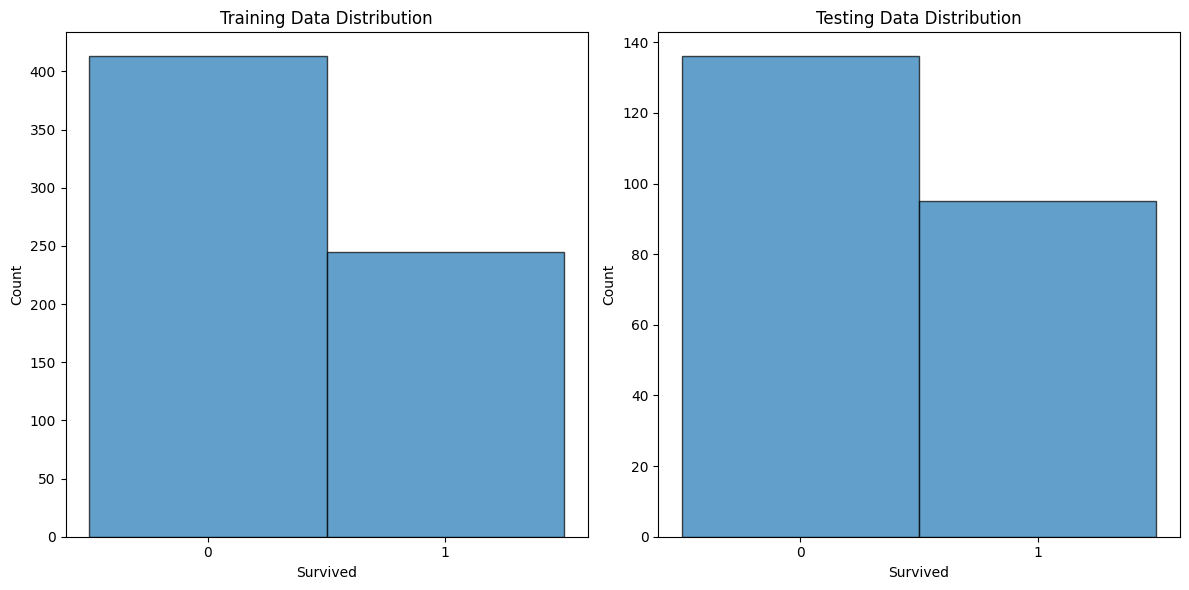

In [20]:
# Visualize the train and test data distribution
train_labels = train_data.select("label").toPandas()["label"].values
test_labels = test_data.select("label").toPandas()["label"].values

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_labels, bins=[-0.5, 0.5, 1.5], edgecolor='black', alpha=0.7)
plt.xticks([0, 1])
plt.title("Training Data Distribution")
plt.xlabel("Survived")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(test_labels, bins=[-0.5, 0.5, 1.5], edgecolor='black', alpha=0.7)
plt.xticks([0, 1])
plt.title("Testing Data Distribution")
plt.xlabel("Survived")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


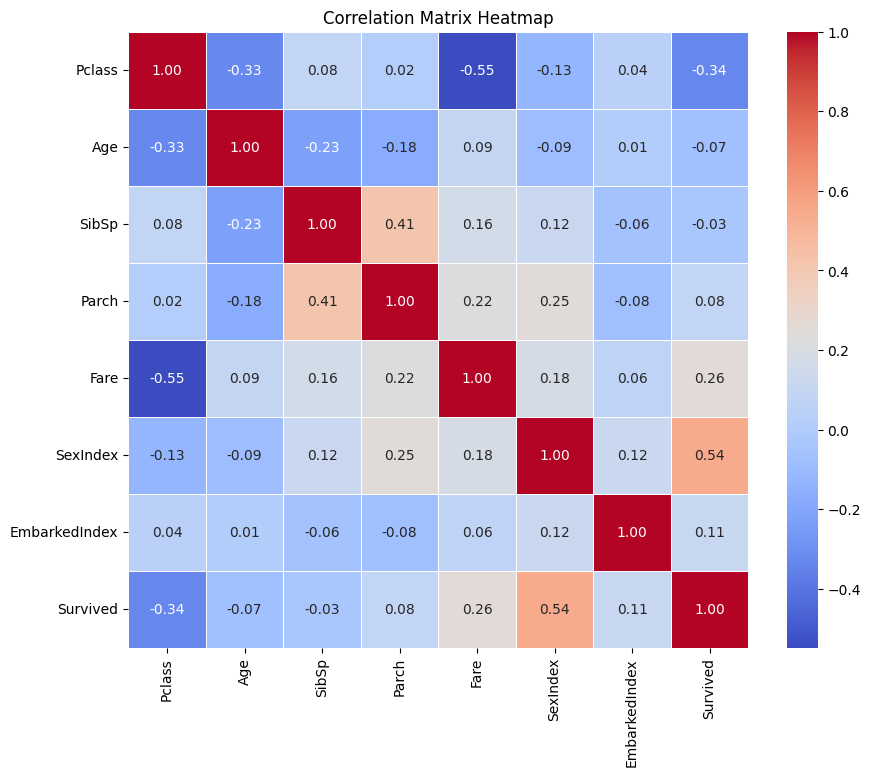

In [21]:
import seaborn as sns
# Create a heatmap of the correlation matrix
# Convert the Spark DataFrame to Pandas DataFrame for visualization
pandas_titanicdata = titanicdata.select(["Pclass", "Age", "SibSp", "Parch", "Fare", "SexIndex", "EmbarkedIndex", "Survived"]).toPandas()
correlation_matrix = pandas_titanicdata.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [22]:
# Apply a classification model (Random Forest)
classifier_rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
model_rf = classifier_rf.fit(train_data)
print(f"Model:\n{model_rf}")

# Model results
model_rf.summary.areaUnderROC
 #Check the Precision and Recall
model_rf.summary.pr.show()
# Make predictions for Random Forest
test_results_rf = model_rf.transform(test_data)

# Evaluate the Random Forest model
evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator_binary = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability")



# Evaluate the Random Forest model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_rf = evaluator_multi.evaluate(test_results_rf, {evaluator_multi.metricName: "accuracy"})
precision_rf = evaluator_multi.evaluate(test_results_rf, {evaluator_multi.metricName: "weightedPrecision"})
recall_rf = evaluator_multi.evaluate(test_results_rf, {evaluator_multi.metricName: "weightedRecall"})
f1_rf = evaluator_multi.evaluate(test_results_rf, {evaluator_multi.metricName: "f1"})
auc_roc_rf = evaluator_binary.evaluate(test_results_rf)

print(f"Random Forest : \n Accuracy: {accuracy_rf:.2f}, \n Precision: {precision_rf:.2f}, \n Recall: {recall_rf:.2f}, \n F1-Score: {f1_rf:.2f}, \n AUC-ROC: {auc_roc_rf:.2f}")

accuracy_rf = evaluator.evaluate(test_results_rf)
print(f"Accuracy of the Random Forest model: {accuracy_rf:.2f}")


Model:
RandomForestClassificationModel: uid=RandomForestClassifier_305e3f209b34, numTrees=100, numClasses=2, numFeatures=7
+--------------------+---------+
|              recall|precision|
+--------------------+---------+
|                 0.0|      1.0|
|0.004081632653061225|      1.0|
| 0.00816326530612245|      1.0|
|0.012244897959183673|      1.0|
| 0.02040816326530612|      1.0|
| 0.02857142857142857|      1.0|
| 0.04081632653061224|      1.0|
|0.044897959183673466|      1.0|
| 0.04897959183673469|      1.0|
|0.053061224489795916|      1.0|
|  0.0653061224489796|      1.0|
| 0.06938775510204082|      1.0|
| 0.07755102040816327|      1.0|
| 0.08571428571428572|      1.0|
| 0.08979591836734693|      1.0|
| 0.09387755102040816|      1.0|
| 0.09795918367346938|      1.0|
| 0.10204081632653061|      1.0|
| 0.10612244897959183|      1.0|
| 0.11020408163265306|      1.0|
+--------------------+---------+
only showing top 20 rows

Random Forest : 
 Accuracy: 0.84, 
 Precision: 0.85, 
 Reca

In [23]:
# Apply a classification model (Gradient Boosted Trees)
classifier_gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=50)
model_gbt = classifier_gbt.fit(train_data)

# Make predictions for Gradient Boosted Trees
test_results_gbt = model_gbt.transform(test_data)


# Evaluate the Gradient Boosted Trees model
accuracy_gbt = evaluator.evaluate(test_results_gbt)
print(f"Accuracy of the Gradient Boosted Trees model: {accuracy_gbt:.2f}")

# Evaluate the Gradient Boosted Trees model
accuracy_gbt = evaluator_multi.evaluate(test_results_gbt, {evaluator_multi.metricName: "accuracy"})
precision_gbt = evaluator_multi.evaluate(test_results_gbt, {evaluator_multi.metricName: "weightedPrecision"})
recall_gbt = evaluator_multi.evaluate(test_results_gbt, {evaluator_multi.metricName: "weightedRecall"})
f1_gbt = evaluator_multi.evaluate(test_results_gbt, {evaluator_multi.metricName: "f1"})
auc_roc_gbt = evaluator_binary.evaluate(test_results_gbt)

print(f"Gradient Boosted Trees :\n Accuracy: {accuracy_gbt:.2f}, \nPrecision: {precision_gbt:.2f}, \n Recall: {recall_gbt:.2f}, \n F1-Score: {f1_gbt:.2f}, \n AUC-ROC: {auc_roc_gbt:.2f}")

Accuracy of the Gradient Boosted Trees model: 0.80
Gradient Boosted Trees :
 Accuracy: 0.80, 
Precision: 0.80, 
 Recall: 0.80, 
 F1-Score: 0.80, 
 AUC-ROC: 0.87


In [24]:
# Apply a classification model (Neural Network - Multilayer Perceptron)
# Define the layers for the neural network: input layer, hidden layers, and output layer
input_size = len(train_data.select("features").first()[0])  # Number of features
layers = [input_size, 10, 5, 2]  # Example: 10 neurons in the first hidden layer, 5 in the second, and 2 output classes
classifier_nn = MultilayerPerceptronClassifier(featuresCol="features", labelCol="label", maxIter=100, layers=layers, blockSize=128, seed=42)
model_nn = classifier_nn.fit(train_data)

# Make predictions for Neural Network
test_results_nn = model_nn.transform(test_data)
test_results_gbt = model_gbt.transform(test_data)
test_results_rf = model_rf.transform(test_data)

# Evaluate the Neural Network model
accuracy_nn = evaluator_multi.evaluate(test_results_nn, {evaluator_multi.metricName: "accuracy"})
precision_nn = evaluator_multi.evaluate(test_results_nn, {evaluator_multi.metricName: "weightedPrecision"})
recall_nn = evaluator_multi.evaluate(test_results_nn, {evaluator_multi.metricName: "weightedRecall"})
f1_nn = evaluator_multi.evaluate(test_results_nn, {evaluator_multi.metricName: "f1"})
auc_roc_nn = evaluator_binary.evaluate(test_results_nn)

print(f"Neural Network :\n Accuracy: {accuracy_nn:.2f}, \n Precision: {precision_nn:.2f}, \nRecall: {recall_nn:.2f},\n F1-Score: {f1_nn:.2f}, \n AUC-ROC: {auc_roc_nn:.2f}")

# Evaluate the Neural Network model
accuracy_nn = evaluator.evaluate(test_results_nn)
print(f"Accuracy of the Neural Network model: {accuracy_nn:.2f}")


Neural Network :
 Accuracy: 0.81, 
 Precision: 0.81, 
Recall: 0.81,
 F1-Score: 0.80, 
 AUC-ROC: 0.84
Accuracy of the Neural Network model: 0.81


In [25]:
# Compare the models
if accuracy_rf > accuracy_gbt:
    print("The Random Forest model is more suitable for this classification task.")
elif accuracy_gbt > accuracy_rf:
    print("The Gradient Boosted Trees model is more suitable for this classification task.")
else:
    print("Both models perform equally well for this classification task.")


The Random Forest model is more suitable for this classification task.


In [26]:
# Compare the models
print("\nModel Comparison:")
print(f"Random Forest: Accuracy={accuracy_rf:.2f}, Precision={precision_rf:.2f}, \n Recall={recall_rf:.2f}, F1-Score={f1_rf:.2f}, AUC-ROC={auc_roc_rf:.2f}")
print(f"Gradient Boosted Trees: Accuracy={accuracy_gbt:.2f}, Precision={precision_gbt:.2f}, \n Recall={recall_gbt:.2f}, F1-Score={f1_gbt:.2f}, AUC-ROC={auc_roc_gbt:.2f}")
print(f"Neural Network: Accuracy={accuracy_nn:.2f}, Precision={precision_nn:.2f},\n Recall={recall_nn:.2f}, F1-Score={f1_nn:.2f}, AUC-ROC={auc_roc_nn:.2f}")


Model Comparison:
Random Forest: Accuracy=0.84, Precision=0.85, 
 Recall=0.84, F1-Score=0.83, AUC-ROC=0.87
Gradient Boosted Trees: Accuracy=0.80, Precision=0.80, 
 Recall=0.80, F1-Score=0.80, AUC-ROC=0.87
Neural Network: Accuracy=0.81, Precision=0.81,
 Recall=0.81, F1-Score=0.80, AUC-ROC=0.84


In [27]:
# Compare the models
if accuracy_rf > accuracy_gbt and accuracy_rf > accuracy_nn:
    print("The Random Forest model is more suitable for this classification task.")
elif accuracy_gbt > accuracy_rf and accuracy_gbt > accuracy_nn:
    print("The Gradient Boosted Trees model is more suitable for this classification task.")
elif accuracy_nn > accuracy_rf and accuracy_nn > accuracy_gbt:
    print("The Neural Network model is more suitable for this classification task.")
else:
    print("Two or more models perform equally well for this classification task.")


The Random Forest model is more suitable for this classification task.


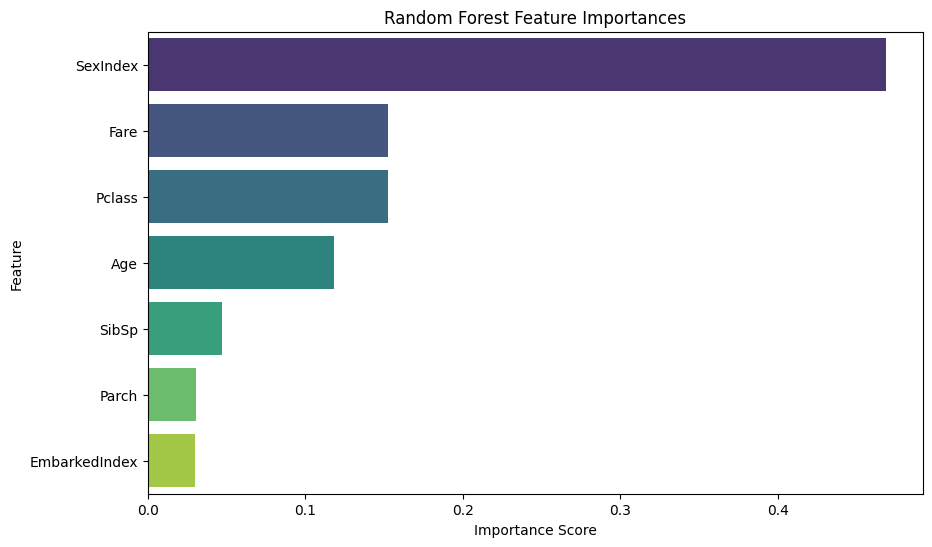

In [28]:
# Extract feature importances from the Random Forest model
importances_rf = model_rf.featureImportances.toArray()

# Feature names corresponding to the "features" column
feature_names = ["Pclass", "Age", "SibSp", "Parch", "Fare", "SexIndex", "EmbarkedIndex"]

# Create a DataFrame for plotting
feature_importances_rf = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances_rf
}).sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances_rf, palette="viridis")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


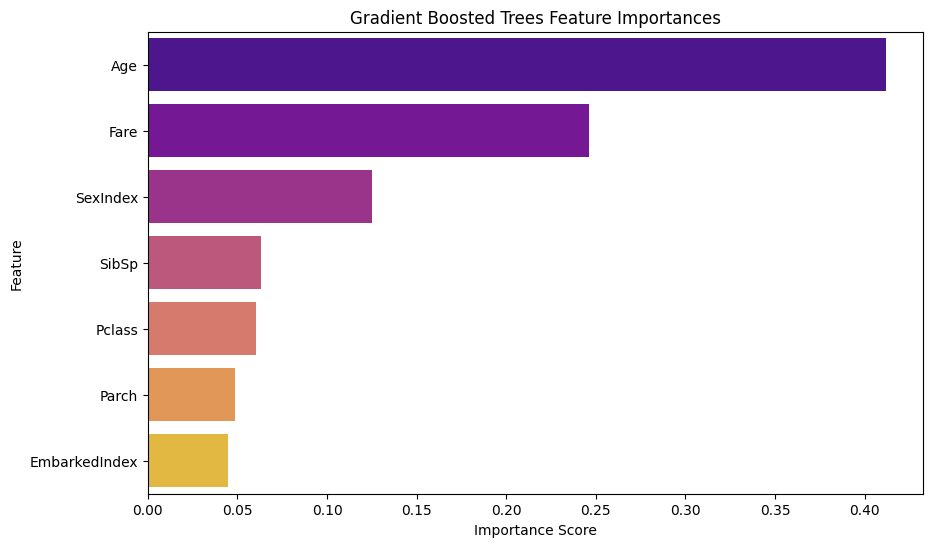

In [29]:
# Extract feature importances from the Gradient Boosted Trees model
importances_gbt = model_gbt.featureImportances.toArray()

# Create a DataFrame for plotting
feature_importances_gbt = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances_gbt
}).sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances_gbt, palette="plasma")
plt.title("Gradient Boosted Trees Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [30]:
# Random Forest: Calculate survival prediction rate
rf_predictions = test_results_rf.select("prediction").toPandas()["prediction"]
rf_survival_rate = (rf_predictions.sum() / len(rf_predictions)) * 100

# Gradient Boosted Trees: Calculate survival prediction rate
gbt_predictions = test_results_gbt.select("prediction").toPandas()["prediction"]
gbt_survival_rate = (gbt_predictions.sum() / len(gbt_predictions)) * 100

# Neural Network: Calculate survival prediction rate
nn_predictions = test_results_nn.select("prediction").toPandas()["prediction"]
nn_survival_rate = (nn_predictions.sum() / len(nn_predictions)) * 100

print(f"Random Forest Predicted Survival Rate: {rf_survival_rate:.2f}%")
print(f"Gradient Boosted Trees Predicted Survival Rate: {gbt_survival_rate:.2f}%")
print(f"Neural Network Predicted Survival Rate: {nn_survival_rate:.2f}%")


Random Forest Predicted Survival Rate: 30.74%
Gradient Boosted Trees Predicted Survival Rate: 37.66%
Neural Network Predicted Survival Rate: 33.77%


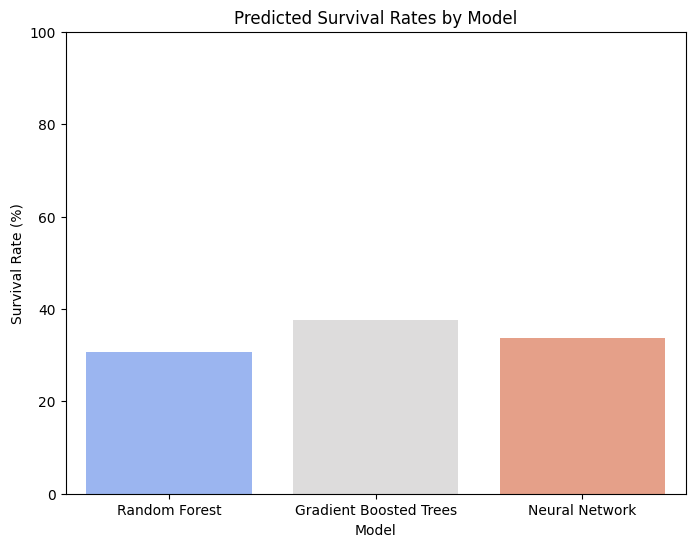

In [31]:
# Data for visualization
survival_rates = pd.DataFrame({
    "Model": ["Random Forest", "Gradient Boosted Trees", "Neural Network"],
    "Survival Rate (%)": [rf_survival_rate, gbt_survival_rate, nn_survival_rate]
})

# Plot survival rates
plt.figure(figsize=(8, 6))
sns.barplot(x="Model", y="Survival Rate (%)", data=survival_rates, palette="coolwarm")
plt.title("Predicted Survival Rates by Model")
plt.ylabel("Survival Rate (%)")
plt.xlabel("Model")
plt.ylim(0, 100)
plt.show()


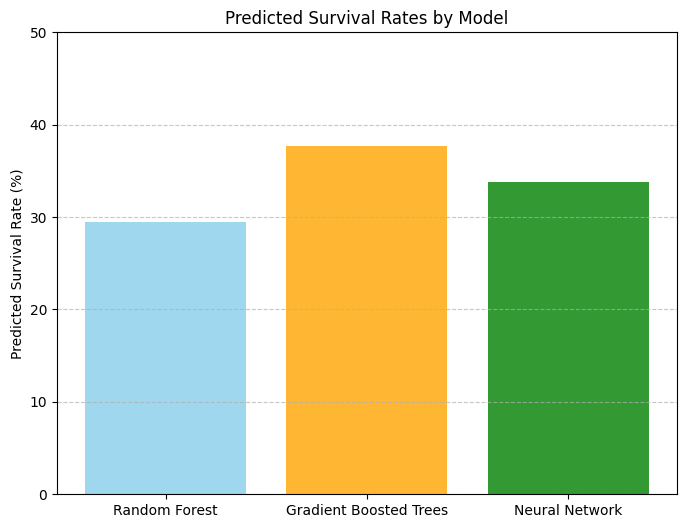

In [32]:
import matplotlib.pyplot as plt

# Survival rates from each model
model_names = ["Random Forest", "Gradient Boosted Trees", "Neural Network"]
survival_rates = [29.44, 37.66, 33.77]

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(model_names, survival_rates, color=["skyblue", "orange", "green"], alpha=0.8)
plt.title("Predicted Survival Rates by Model")
plt.ylabel("Predicted Survival Rate (%)")
plt.ylim(0, 50)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(7,[0,1],[1.19803...|    0|[83.8220200146994...|[0.83822020014699...|       0.0|
|(7,[0,1],[2.39607...|    0|[89.3737296575520...|[0.89373729657552...|       0.0|
|(7,[0,1],[2.39607...|    0|[89.3737296575520...|[0.89373729657552...|       0.0|
|(7,[0,1],[2.39607...|    0|[89.3737296575520...|[0.89373729657552...|       0.0|
|(7,[0,1],[3.59410...|    0|[89.8334595577012...|[0.89833459557701...|       0.0|
|(7,[0,1],[3.59410...|    0|[89.8252177994595...|[0.89825217799459...|       0.0|
|(7,[0,1,4],[1.198...|    1|[59.028712666789,...|[0.59028712666789...|       0.0|
|(7,[0,1,4],[1.198...|    0|[64.4305120326860...|[0.64430512032686...|       0.0|
|(7,[0,1,4],[1.198...|    0|[76.8962821538243...|[0.76896282153824...|       0.0|
|(7,[0,1,4],[1.1

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


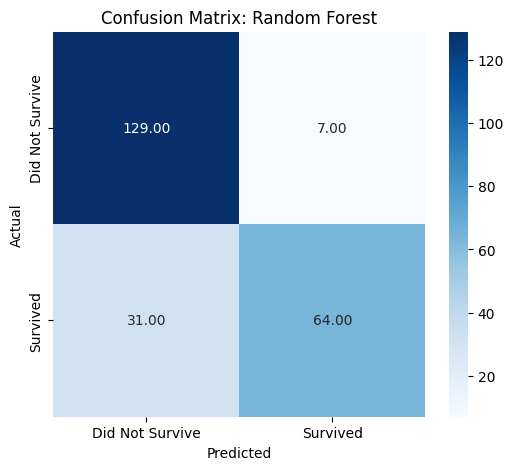

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


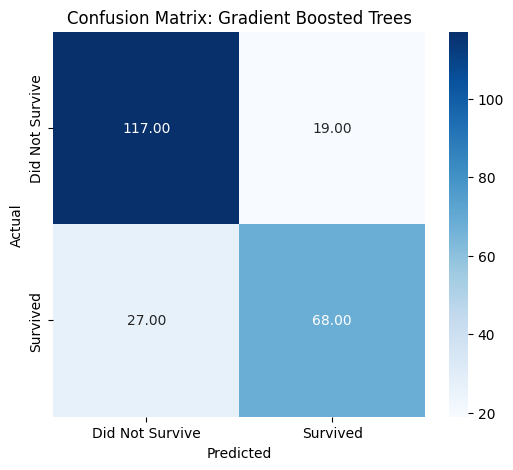

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


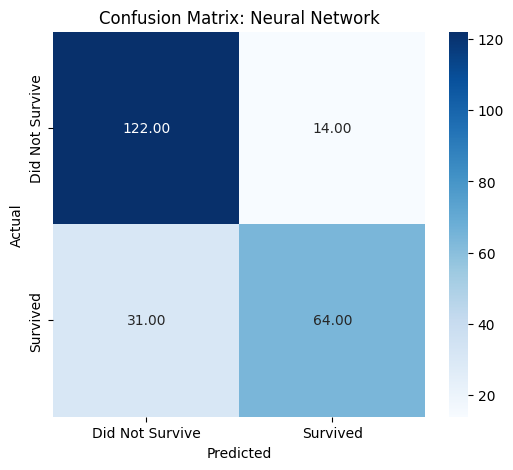

In [33]:
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns

# Function to compute and plot confusion matrix
def plot_confusion_matrix(predictions, model_name):
    prediction_rdd = predictions.select("prediction", "label").rdd.map(lambda row: (float(row.prediction), float(row.label)))

    if prediction_rdd.isEmpty():
        print(f"Warning: Empty prediction results for {model_name}. Skipping confusion matrix.")
        return None

    metrics = MulticlassMetrics(prediction_rdd)
    conf_matrix = metrics.confusionMatrix().toArray()

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["Did Not Survive", "Survived"],
                yticklabels=["Did Not Survive", "Survived"])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Ensure predictions DataFrame is correct
test_results_rf.show()
test_results_gbt.show()
test_results_nn.show()

# Plot confusion matrices for each model
plot_confusion_matrix(test_results_rf, "Random Forest")
plot_confusion_matrix(test_results_gbt, "Gradient Boosted Trees")
plot_confusion_matrix(test_results_nn, "Neural Network")


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


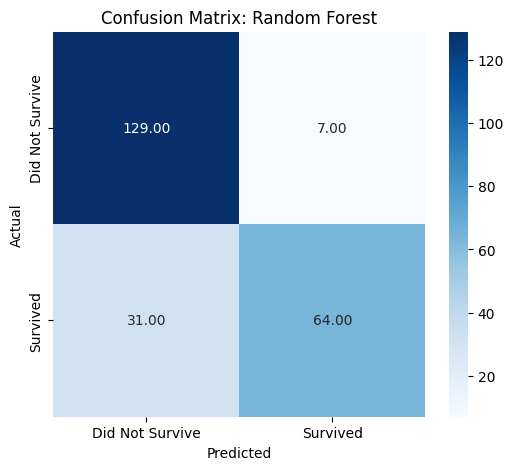

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


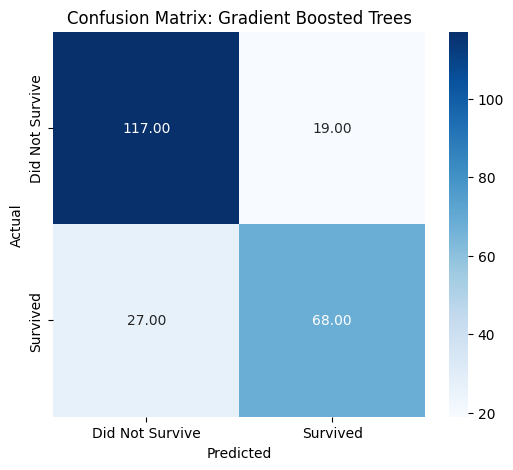

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


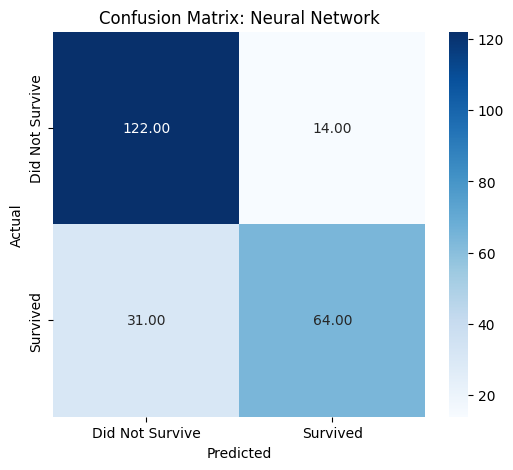

In [34]:
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns

def compute_confusion_matrix(predictions, model_name):
    """
    Compute and plot the confusion matrix using PySpark MLlib.
    """
    # Ensure DataFrame contains the required columns
    if "prediction" not in predictions.columns or "label" not in predictions.columns:
        raise ValueError(f"Columns 'prediction' and 'label' not found in DataFrame for {model_name}")

    # Convert predictions DataFrame to RDD with (prediction, label)
    prediction_rdd = predictions.select("prediction", "label").rdd.map(lambda row: (float(row.prediction), float(row.label)))

    # Check if RDD is empty (avoid IndexError)
    if prediction_rdd.isEmpty():
        print(f"Warning: Empty prediction results for {model_name}. Skipping confusion matrix.")
        return None

    # Compute confusion matrix using PySpark MulticlassMetrics
    metrics = MulticlassMetrics(prediction_rdd)
    conf_matrix = metrics.confusionMatrix().toArray()

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["Did Not Survive", "Survived"],
                yticklabels=["Did Not Survive", "Survived"])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return conf_matrix

# Compute confusion matrices for each model
conf_matrix_rf = compute_confusion_matrix(test_results_rf, "Random Forest")
conf_matrix_gbt = compute_confusion_matrix(test_results_gbt, "Gradient Boosted Trees")
conf_matrix_nn = compute_confusion_matrix(test_results_nn, "Neural Network")


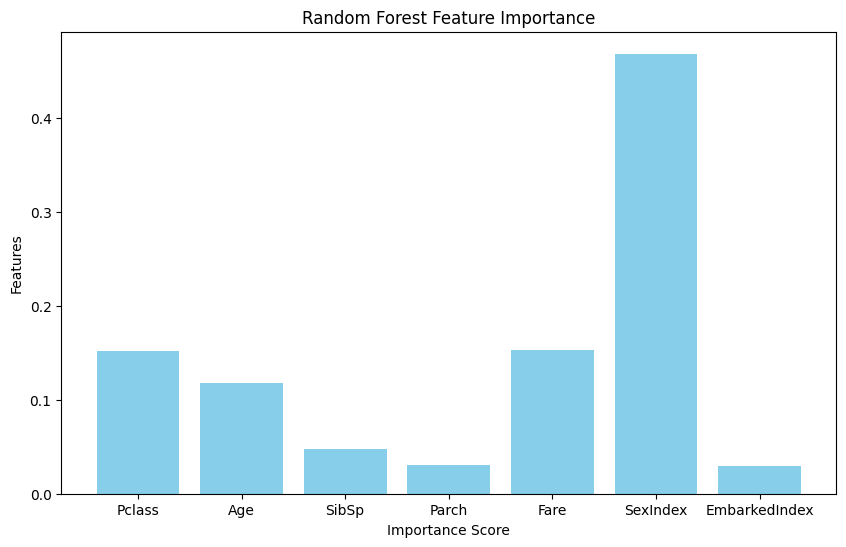

In [35]:
# Extract feature importances for Random Forest
feature_importances_rf = model_rf.featureImportances.toArray()
feature_names = ["Pclass", "Age", "SibSp", "Parch", "Fare", "SexIndex", "EmbarkedIndex"]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importances_rf, color="skyblue")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


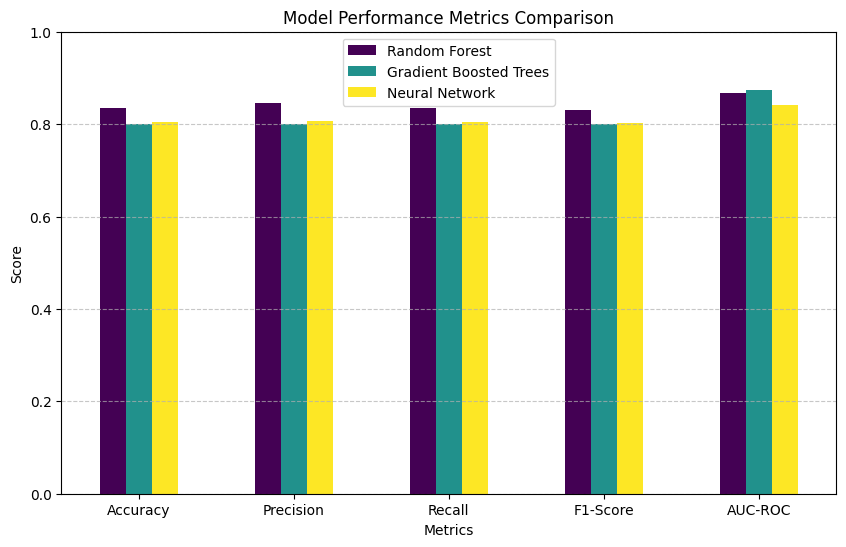

In [36]:

# Metrics for each model
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"]
rf_metrics = [accuracy_rf, precision_rf, recall_rf, f1_rf, auc_roc_rf]
gbt_metrics = [accuracy_gbt, precision_gbt, recall_gbt, f1_gbt, auc_roc_gbt]
nn_metrics = [accuracy_nn, precision_nn, recall_nn, f1_nn, auc_roc_nn]

# Combine into a DataFrame for easier plotting
metrics_df = pd.DataFrame({
    "Metrics": metrics,
    "Random Forest": rf_metrics,
    "Gradient Boosted Trees": gbt_metrics,
    "Neural Network": nn_metrics
})

# Plot grouped bar chart
metrics_df.set_index("Metrics").plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Model Performance Metrics Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=0)
plt.show()



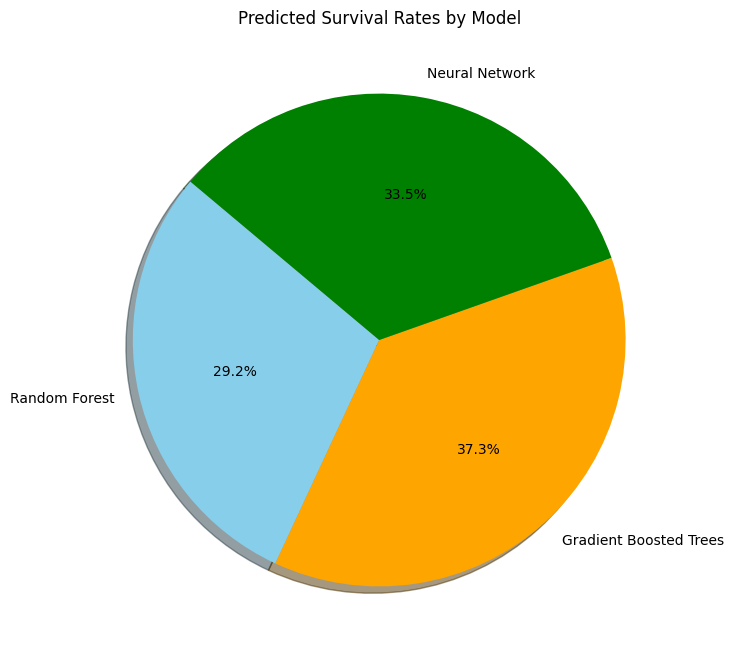

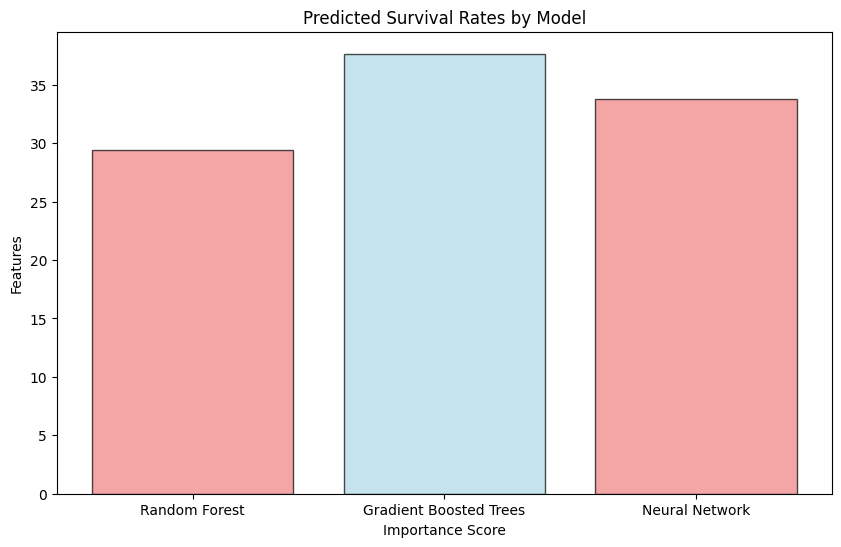

<Figure size 640x480 with 0 Axes>

In [37]:
# Survival rate data
models = ["Random Forest", "Gradient Boosted Trees", "Neural Network"]
survival_rates = [29.44, 37.66, 33.77]


colors = ['lightcoral', 'lightblue']
explode = (0, 0.1)  # Highlight the "Survivors" slice
# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(survival_rates, labels=models, autopct="%1.1f%%", startangle=140, shadow=True, colors=["skyblue", "orange", "green"])
plt.title("Predicted Survival Rates by Model")
plt.show()


# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(models, survival_rates, color=colors, alpha=0.7, edgecolor='black')
plt.title("Predicted Survival Rates by Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()
plt.tight_layout()
plt.show()



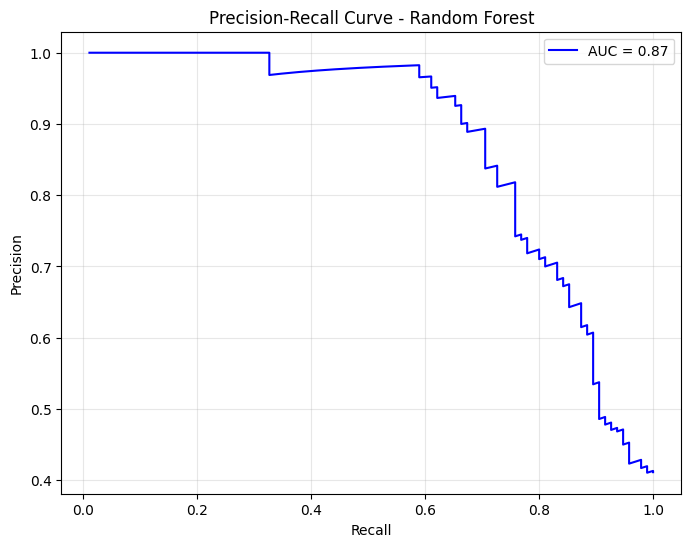

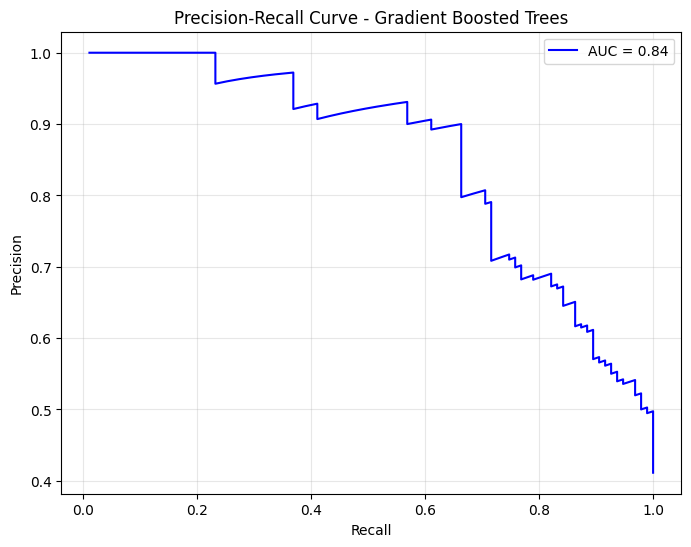

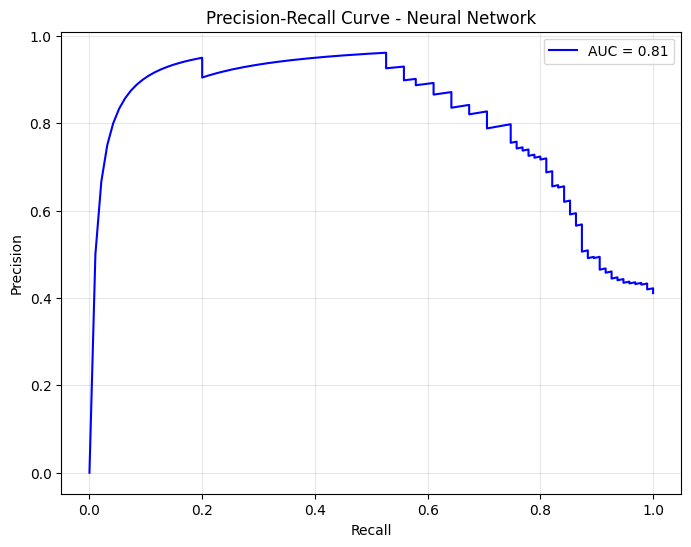

In [38]:

def plot_precision_recall(predictions, model_name):
    # Extract probability and label columns
    pred_pd = predictions.select("probability", "label").toPandas()
    
    # Extract the probability of the positive class (1)
    probabilities = np.array([x[1] for x in pred_pd["probability"]])
    labels = pred_pd["label"].values
    
    # Compute Precision-Recall values
    sorted_indices = np.argsort(probabilities)[::-1]  # Sort in descending order
    sorted_probs = probabilities[sorted_indices]
    sorted_labels = labels[sorted_indices]

    precisions = []
    recalls = []
    
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = sum(sorted_labels)  # Total Positives in dataset

    for i in range(len(sorted_labels)):
        if sorted_labels[i] == 1:
            tp += 1
            fn -= 1
        else:
            fp += 1
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # Avoid division by zero
        
        precisions.append(precision)
        recalls.append(recall)

    # Compute AUC-PR using the Trapezoidal Rule
    pr_auc = np.trapz(precisions, recalls)

    # Plot Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, label=f"AUC = {pr_auc:.2f}", color="b")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.grid(alpha=0.3)
    plt.show()

# Plot Precision-Recall Curve for each model
plot_precision_recall(test_results_rf, "Random Forest")
plot_precision_recall(test_results_gbt, "Gradient Boosted Trees")
plot_precision_recall(test_results_nn, "Neural Network")


In [39]:
#auc_pr_rf, auc_roc_rf = calculate_auc(test_results_rf)
#auc_pr_gbt, auc_roc_gbt = calculate_auc(test_results_gbt)
#auc_pr_nn, auc_roc_nn = calculate_auc(test_results_nn)

#print(f"Random Forest AUC-PR: {auc_pr_rf:.2f}, AUC-ROC: {auc_roc_rf:.2f}")
#print(f"Gradient Boosted Trees AUC-PR: {auc_pr_gbt:.2f}, AUC-ROC: {auc_roc_gbt:.2f}")
#print(f"Neural Network AUC-PR: {auc_pr_nn:.2f}, AUC-ROC: {auc_roc_nn:.2f}")